In [1]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from pylab import cm

np.random.seed(123)

# Values that you may want to change

In [2]:
out_dir = "../out/"
model_ready_data_fpath = out_dir + 'model_ready_sequences.npz'
train_data_fpath = out_dir + 'train_data.npz'
valid_data_fpath = out_dir + 'valid_data.npz'
test_data_fpath = out_dir + 'test_data.npz'

mapping_reference = "../in/MN_ice/raw_data_from_DNR/lake_ice_id_spreadsheet.xlsx"

date_format = '%Y-%m-%d'

# Import

In [3]:
model_ready_data = np.load(model_ready_data_fpath, allow_pickle = True)

lat_lon_ref_df = pd.read_excel(mapping_reference,
                               usecols=['dow num', 'lat', 'long'])

In [4]:
x = model_ready_data['x']
y = model_ready_data['y']
dates =  model_ready_data['dates']
DOW =  model_ready_data['DOW']
variables =  model_ready_data['vars']

print('Number of sequences before this work... ', str(x.shape[0]))

Number of sequences before this work...  5104


# Demonstrate existing data missingness

In [5]:
# We dont really need the 366th day after July 1 on leap years
#   because it will almost surely be ice free.
# Additionally, the 366th day is nan for non leap years.
temporary_x = x[:, :365, :].copy()

# Determine how many sequences have a NaN present for each variable
for i in range(len(variables)):
    nan_free_seq_count = 0
    for j in range(temporary_x.shape[0]):
        if np.sum(np.isnan(temporary_x[j, :, i])) == 0:
            nan_free_seq_count += 1
    print(i, variables[i], '\t\t', np.round(nan_free_seq_count / temporary_x.shape[0], 2))

0 ShortWave 		 0.89
1 LongWave 		 0.89
2 AirTemp 		 0.89
3 RelHum 		 0.89
4 WindSpeed 		 0.89
5 Rain 		 0.89
6 Snow 		 0.89
7 kd 		 0.85
8 ice 		 0.85
9 rad_0 		 0.85
10 temp_0_x 		 0.85
11 temp_0_y 		 0.68
12 temp_MaxDepth_x 		 0.85
13 temp_MaxDepth_y 		 0.68
14 MaxDepth 		 0.89


**Working decision:** dont use PGDL estimates for water temperature because they are missing too often.

# Omit variables or rows that provide missingness

### Omit variables

In [6]:
non_omitted_variables = []
for i in np.concatenate([variables[:11], variables[[-3]], variables[[-1]]]):
    non_omitted_variables.append(i)
print(non_omitted_variables)
    
improved_x = np.concatenate([temporary_x[:, :, :11],
                             temporary_x[:, :, [-3]],
                             temporary_x[:, :, [-1]]],
                            axis = 2)
del(temporary_x)

['ShortWave', 'LongWave', 'AirTemp', 'RelHum', 'WindSpeed', 'Rain', 'Snow', 'kd', 'ice', 'rad_0', 'temp_0_x', 'temp_MaxDepth_x', 'MaxDepth']


### Omit rows

In [7]:
# Determine where data is missing and what percent are missing
nan_free_seq_count = 0
nan_free_indices = []
for j in range(improved_x.shape[0]):
    if np.sum(np.isnan(improved_x[j])) == 0:
        nan_free_seq_count += 1
        nan_free_indices.append(j)
nan_free_indices = np.asarray(nan_free_indices)

perc_missing = 1  - (nan_free_seq_count / improved_x.shape[0])
perc_missing

0.14792319749216298

In [8]:
improved_x = improved_x[nan_free_indices]
# Also get rid of that extra day on leap years here
y = y[nan_free_indices, :365]
dates = dates[nan_free_indices, :365]
DOW = DOW[nan_free_indices].astype(int)
variables = non_omitted_variables

In [9]:
print('Number of sequences remaining... ', str(improved_x.shape[0]))

Number of sequences remaining...  4349


# Identify partitions by lake identifier (DOW)

Train, validation, and test sets will be mutually exclusive sets of different lakes. Data from these lake sets should approximately span the entire temporal range

In [10]:
df = pd.DataFrame({"DOW":DOW.astype(int),
                   "dates":dates[:, 0].astype(np.datetime64)})
df = df.dropna()
df['dates'] = df['dates'].astype(np.datetime64)

### Figure out what % of the data each lake represents

In [11]:
DOW_value_counts = df['DOW'].value_counts()
DOW_proportions = DOW_value_counts / len(df)
DOW_proportions = pd.DataFrame(DOW_proportions)
DOW_proportions = DOW_proportions.reset_index()
DOW_proportions = DOW_proportions.rename(columns = {'DOW':'prop',
                                                    'index':'DOW'})
DOW_proportions

,DOW,prop
0,10005900,0.008738
1,34007900,0.008738
2,4013000,0.008738
3,29025000,0.008508
4,27013300,0.008508
...,...,...
620,40006300,0.000230
621,4013001,0.000230
622,4021700,0.000230
623,47004901,0.000230


### Randomly sample lakes until we get 20% of the data

In [12]:
def partition_by_lakes(dataset, possible_lakes, desired_prop):
    
    # arguments
    #     `dataset` is the dataset we're partitioning.
    #        I assume it has a "DOW" column
    #     `possible_lakes` are the DOWs that we sample.
    #        As the sampling continues, we remove values.
    #     `desired_prop` is the proportion of the data set
    #        that we want this partition to cover.
    # returns
    #     `partition_lakes` are the random DOWs representing
    #        the desired proportion of the data set
    #     `possible_lakes` are the reduced DOWs that we can
    #        further sample for additional partitions.
    
    partition_lakes = []
    cumulative_sum = 0 

    while cumulative_sum < 0.2:
        # add a random new lake to the partition
        rand_DOW = np.random.choice(possible_DOWs)
        partition_lakes.append(rand_DOW)

        # subset the data set to those sampled partitions
        # and determine what % we are at
        cumulative_subset = dataset[dataset.DOW.isin(partition_lakes)]
        cumulative_sum = np.sum(cumulative_subset['prop'])

        # sample without replacement
        possible_DOWs.remove(rand_DOW)

    # State what literal proportion we achieved and
    # how many lakes that represents
    print(cumulative_sum, len(partition_lakes))
    
    return(partition_lakes, possible_lakes)

In [13]:
possible_DOWs = list(DOW_proportions['DOW'].copy())

valid_lakes, possible_DOWs = partition_by_lakes(DOW_proportions,
                                                possible_DOWs,
                                                0.2)
test_lakes, possible_DOWs = partition_by_lakes(DOW_proportions,
                                               possible_DOWs,
                                               0.2)

0.20027592550011497 131
0.2000459875833526 127


In [14]:
DOW_proportions['train'] = DOW_proportions.DOW.isin(possible_DOWs)
DOW_proportions['valid'] = DOW_proportions.DOW.isin(valid_lakes)
DOW_proportions['test'] = DOW_proportions.DOW.isin(test_lakes)

# Very basic mapping of the partitions

In [15]:
lat_lon_ref_df = lat_lon_ref_df.rename(columns = {'dow num':'DOW'})
lat_lon_ref_df = lat_lon_ref_df.merge(DOW_proportions, on='DOW')

seq_DOWs = pd.DataFrame({'DOW':DOW})

mapping_df = seq_DOWs.merge(lat_lon_ref_df, on='DOW', how = 'left')
mapping_df.head()

,DOW,lat,long,prop,train,valid,test
0,10000600,44.87739,-93.52961,0.00023,True,False,False
1,10000900,44.87861,-93.60831,0.00161,False,False,True
2,10000900,44.87861,-93.60831,0.00161,False,False,True
3,10000900,44.87861,-93.60831,0.00161,False,False,True
4,10000900,44.87861,-93.60831,0.00161,False,False,True


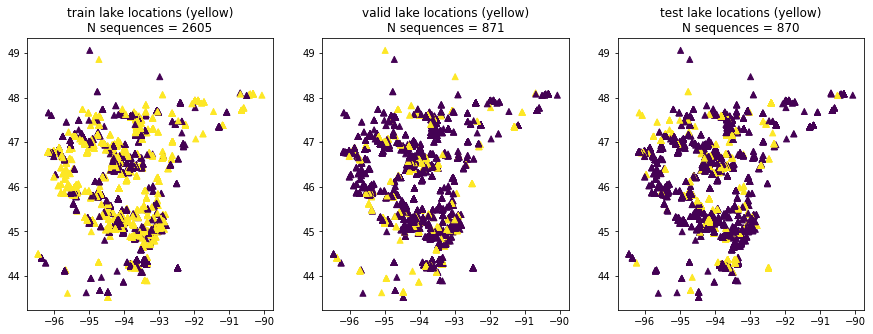

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
cmap = cm.get_cmap('viridis', 2)

count = 0
for col in ['train', 'valid', 'test']:
    ax[count].set_title(col + ' lake locations (yellow)\nN sequences = ' + str(np.sum(mapping_df[col])))
    ax[count].scatter(mapping_df['long'], mapping_df['lat'], cmap = cmap,
                      c = mapping_df[col], marker = '^')
    count += 1

# Actually split the model ready sequences

In [17]:
train_indices = []
valid_indices = []
test_indices = []

count = 0
for dow in DOW:
    if dow in possible_DOWs:
        train_indices.append(count)
    elif dow in valid_lakes:
        valid_indices.append(count)
    elif dow in test_lakes:
        test_indices.append(count)
    else:
        print('WARNING', count)
        
    count += 1

In [18]:
def save_partition_data(indices, fpath):
    # subset all the objects
    part_x = improved_x[indices]
    part_y = y[indices]
    part_dates = dates[indices]
    part_DOW = DOW[indices]
    
    part_data = {'x':part_x,
                 'y':part_y,
                 'dates':part_dates,
                 'DOW':part_DOW,
                 'vars':non_omitted_variables}
    
    np.savez_compressed(fpath, **part_data)

In [19]:
save_partition_data(train_indices, train_data_fpath)
save_partition_data(valid_indices, valid_data_fpath)
save_partition_data(test_indices, test_data_fpath)